# Policy gradient methods cont.
### REINFORCE with baseline and actor-critic methods
RLDMUU, UniNE 2025, jakub.tluczek@unine.ch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

First, let's start with setting up PyTorch. As usual, we get the device on which we will compute everything, and also we will set the random seed to make the results reproducible:

In [2]:
torch.manual_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(123)

In [3]:
# running mean function for the purpose of visualization
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

### REINFORCE WITH BASELINE

Last time we've seen how to implement REINFORCE algorithm, and how standardizing the returns $G$ made learning more stable. Another way to stabilize the learning process by reducing variance is to use some baseline algorithm $b(s)$, which would give us the expected return at state $s$. We can then use another parametrized, differentiable function to approximate the value at a given state. We can reuse the policy $\pi(a|s, \bf{\theta})$ from the previous exercise, while adding a state value function $\hat{v}(s, \bf{w})$, with its own parameters and separate learning rates $\alpha_\theta$ and $\alpha_{\bf{w}}$. Then, just as it was the case with previous exercise, for each episode we collect its trajectory $\tau$ and compute the following:

- generate a trajectory $\tau$ following policy $\pi(\cdot | \cdot, \theta)$
- for each $t$ in $\tau$:
    - $G_t \leftarrow \sum_{k=t+1}^{T} \gamma^{k-t-1} r_k$

Now however, instead of updating the network with discounted rewards in the future, we calculate the advantage term $\delta$ for each timestep $t$:

- $\delta \leftarrow G - \hat{v}(s_t, \bf{w})$

Then value network might be optimized with respect to the advantage term, while the update of the the policy network is conducted as follows:

- $\theta \leftarrow \theta + \alpha_\theta \gamma^t \delta \nabla ln \pi(a_t | s_t, \theta)$

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs, hidden_dim_size):
        super(PolicyNetwork, self).__init__()
        # 2 fully connected layers
        self.linear1 = nn.Linear(n_inputs, hidden_dim_size)
        self.linear2 = nn.Linear(hidden_dim_size, n_outputs)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        # instead of returning one output, let's return logπ together with π
        probs = F.softmax(self.linear2(x), dim=-1)
        log_probs = torch.log(probs)

        return probs, log_probs

In [7]:
# TODO: Implement the value network
class ValueNetwork(nn.Module):
    def __init__(self, num_states, hidden_dim):
        super(ValueNetwork, self).__init__()
        self.linear1 = nn.Linear(num_states, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        return self.linear2(x)

In [8]:
# TODO: initialize the value network and its parameters
policy = PolicyNetwork(n_inputs=4, n_outputs=2, hidden_dim_size=128).to(device)
value = ValueNetwork(num_states=4, hidden_dim=128).to(device)
policy_optimizer = torch.optim.Adam(params=policy.parameters(), lr=8e-4)
value_optimizer = torch.optim.Adam(params=value.parameters(), lr=1e-3)

We are still going to use the `CartPole` environment:

In [9]:
env = gym.make('CartPole-v1')

REINFORCE with baseline main loop:

In [10]:
NUM_TRAJECTORIES = 2000
MAX_EPISODE_LENGTH = 500
gamma = 0.9
# placeholders for rewards for each episode
rewards = []
policy_losses = []
value_losses = []
# iterating through trajectories
for tau in tqdm(range(NUM_TRAJECTORIES)):
    # resetting the environment
    state, info = env.reset()
    # setting done to False for while loop 
    done = False
    # storing trajectory and logπ(a_t|s_t, θ)
    transition_buffer = []
    log_probs = []
    state_values =[]
    
    t = 0
    while done == False and t < MAX_EPISODE_LENGTH:
        # retrieving π and logπ
        action_probs, action_log_probs = policy(torch.tensor(state).to(device))
        # retrieving value of the state we're currently in
        state_value = value(torch.tensor(state).to(device))
        # sampling the action according to the distribution given by π
        action = np.random.choice([0, 1], p=action_probs.flatten().detach().cpu().numpy())
        # keeping track of previous state
        prev_state = state
        # environment step
        state, reward, done, truncation, info = env.step(action)
        # storing rewards, logπ and state values
        transition_buffer.append(reward)
        log_probs.append(action_log_probs[action])
        state_values.append(state_value)

        t += 1
    # logging the episode length as a cumulative reward
    rewards.append(t)
    returns = []
    for t_prime in range(t):
        # computing discounted rewards in future for every timestep
        G = 0
        for i, tick in enumerate(transition_buffer[t_prime:]):
            G += (gamma ** i) * tick
        returns.append(G)

    # turning the returns vector into a tensor
    returns = torch.tensor(returns).to(device)
    # creating the advantage term δ
    deltas = returns - torch.tensor(state_values).to(device)
    
    # computing the gradients for each timestep
    policy_gradients = []
    value_gradients = []
    # using Sutton & Barto losses for value function and policy
    for t, (log_prob, d) in enumerate(zip(log_probs, deltas)):
        policy_gradients.append(- (gamma ** t) * d * log_prob)
    for d, V in zip(deltas, state_values):
        value_gradients.append( - d * V)
    # updating the policy network
    policy_optimizer.zero_grad()
    # summing all gradients for one batch update instead of update at each timestep
    policy_loss = torch.stack(policy_gradients).sum()
    policy_losses.append(policy_loss.item())
    policy_loss.backward()
    policy_optimizer.step()
    # updating the value network
    value_optimizer.zero_grad()
    value_loss = torch.stack(value_gradients).sum()
    value_losses.append(value_loss.item())
    value_loss.backward()
    value_optimizer.step()


100%|██████████| 2000/2000 [02:36<00:00, 12.76it/s]


Text(0.5, 1.0, 'REINFORCE with baseline cumulative rewards')

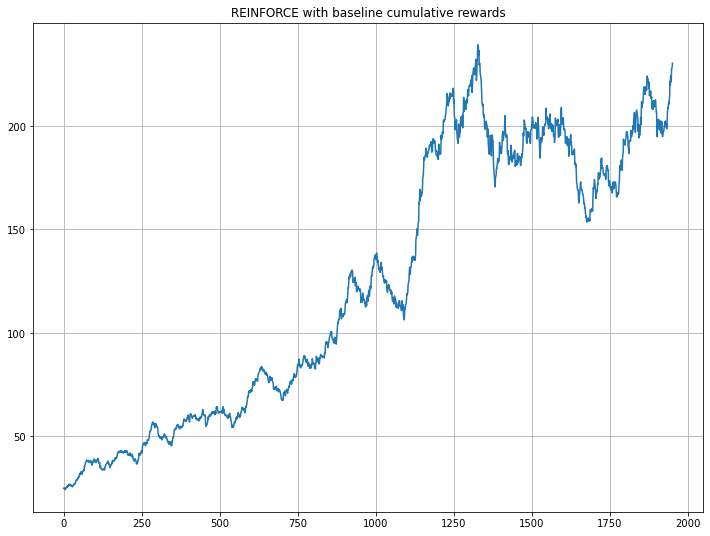

In [11]:
# visualize the results
plt.figure(figsize=(12,9))
plt.plot(running_mean(rewards, 50))
plt.grid()
plt.title("REINFORCE with baseline cumulative rewards")

### 1-step actor-critic

Another approach is to update the policy not at the end of each trajectory, but at each timestep using the 1 step return. Therefore when computing $\delta$ advantage term, we can use not the discounted rewards from all timesteps until the terminal state, but rather:

- $G_{t:t+1} \leftarrow r + \gamma \hat{v}(s', \bf{w})$
- $\delta \leftarrow G_{t:t+1} - \hat{v}(s, \bf{w})$

More specifically, we can use the existing policy to compute the advantage term in the online fashion:

- $\delta \leftarrow r + \gamma \hat{v}_{\pi}(s', \textbf{w}) - \hat{v}(s, \bf{w})$

Then we can update the value network with:

$\theta_v \leftarrow \theta_v + \alpha_\theta \delta^2 \nabla \hat{v}$

and the update for policy network:

$\theta_\pi \leftarrow \theta_\pi + \alpha_\theta \gamma^t \delta \nabla ln \pi(a_t | s_t, \theta)$


First let's reuse the policy and value networks from the previous exercise:

In [16]:
policy = PolicyNetwork(n_inputs=4, n_outputs=2, hidden_dim_size=128).to(device)
value = ValueNetwork(num_states=4, hidden_dim=128).to(device)
policy_optimizer = torch.optim.Adam(params=policy.parameters(), lr=1e-4)
value_optimizer = torch.optim.Adam(params=value.parameters(), lr=1e-3)

In [17]:
NUM_TRAJECTORIES = 1000
MAX_EPISODE_LENGTH = 500
gamma = 0.99
# placeholders for rewards for each episode
rewards = []
policy_losses = []
value_losses = []
# iterating through trajectories
for tau in tqdm(range(NUM_TRAJECTORIES)):
    # resetting the environment
    state, info = env.reset(seed=123)
    # setting done to False for while loop 
    done = False

    t = 0
    while done == False and t < MAX_EPISODE_LENGTH:
        # retrieving π and logπ
        action_probs, action_log_probs = policy(torch.tensor(state).to(device))
        # retrieving value of the state we're currently in
        current_state_value = value(torch.tensor(state).to(device))
        # sampling the action according to the distribution given by π
        action = np.random.choice([0, 1], p=action_probs.flatten().detach().cpu().numpy())
        # keeping track of previous state
        prev_state = state
        # environment step
        state, reward, done, truncation, info = env.step(action)
        # getting the value of next state - no value if the state is terminal
        if done == False:
            next_state_value = value(torch.tensor(state).to(device))
        else:
            next_state_value = torch.tensor(0.).to(device)

        # delta computation
        reward = torch.tensor(reward).to(device)
        # detaching the next state gradients for the value function update 
        delta = reward + gamma * next_state_value.detach() - current_state_value

        # value update
        value_optimizer.zero_grad()
        value_loss = delta ** 2
        value_losses.append(value_loss.item())
        value_loss.backward()
        value_optimizer.step()

        # policy update
        policy_optimizer.zero_grad()
        # detaching the delta time from policy computation graph
        policy_loss = - delta.detach() * action_log_probs[action]
        policy_losses.append(policy_loss.item())
        policy_loss.backward()
        policy_optimizer.step()

        t += 1
    rewards.append(t)

  0%|          | 1/1000 [00:00<01:40,  9.91it/s]

100%|██████████| 1000/1000 [09:24<00:00,  1.77it/s]


Text(0.5, 1.0, '1-step actor-critic cumulative rewards')

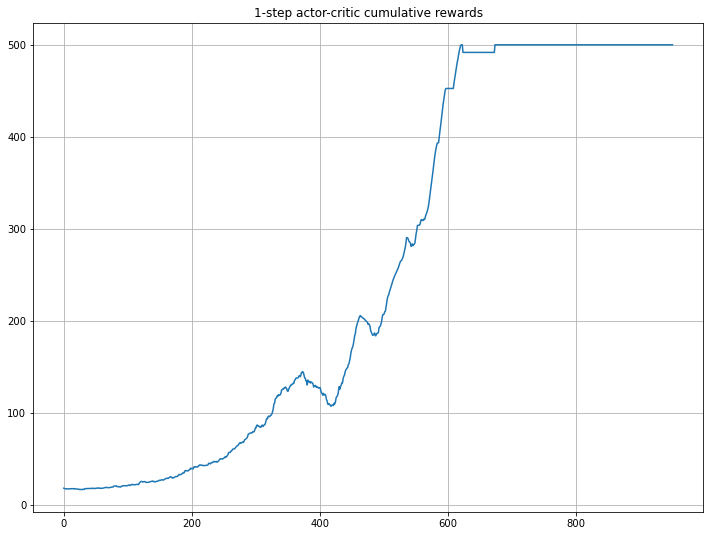

In [18]:
# visualize the results
plt.figure(figsize=(12,9))
plt.plot(running_mean(rewards, 50))
plt.grid()
plt.title("1-step actor-critic cumulative rewards")